In [75]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import csv
import cartopy.crs as ccrs
import networkx as nx
from matplotlib.lines import Line2D 

### Reading in the data

In [76]:
#Read the GraphML file
G = nx.read_graphml('EXPORTED_DATA/G_scc.graphml')

#Display basic information about the graph
#nx.info(G)

In [77]:
#Read in other data files
airports = pd.read_csv('EXPORTED_DATA/nodes.csv').rename(columns={'Unnamed: 0':'id'})
routes = pd.read_csv('EXPORTED_DATA/edges.csv')
geo_df = gpd.read_file('EXPORTED_DATA/UN_geodata.geojson')

## Centrality measures

### Degree centrality 

Which airports have the most connections and are thus most central globally?

In [78]:
degree_centrality = nx.degree_centrality(G)

In [79]:
top_dc = pd.DataFrame(degree_centrality.items())
top_dc.columns =['id', 'degree_centrality']
top_dc = top_dc.sort_values(by=['degree_centrality'], ascending=False)

top_dc['id'] = top_dc['id'].astype(str)
airports['id'] = airports['id'].astype(str)

top_dc = pd.merge(top_dc,
                  airports,
                  on='id',
                  how='inner')

top_dc.head(10)

id  degree_centrality                                              name  \
0   340           0.151621                         Frankfurt am Main Airport   
1  1382           0.149078           Charles de Gaulle International Airport   
2   580           0.147171                        Amsterdam Airport Schiphol   
3  1701           0.143357                     Atatürk International Airport   
4  3682           0.137635  Hartsfield Jackson Atlanta International Airport   
5  3830           0.129688              Chicago O'Hare International Airport   
6  3364           0.129688             Beijing Capital International Airport   
7   346           0.120788                                    Munich Airport   
8  4029           0.119199                  Domodedovo International Airport   
9  3670           0.117928           Dallas Fort Worth International Airport   

                city        country                 region  iso iata  icao  \
0          Frankfurt        Germany  Europe & Central Asia  DEU  FRA  EDDF   
1              Paris         France  Europe & Central Asia  FRA  CDG  LFPG   
2          Amsterdam    Netherlands  Europe & Central Asia  NLD  AMS  EHAM   
3           Istanbul         Turkey  Europe & Central Asia  TUR  ISL  LTBA   
4            Atlanta  United States          North America  USA  ATL  KATL   
5            Chicago  United States          North America  USA  ORD  KORD   
6            Beijing          China    East Asia & Pacific  CHN  PEK  ZBAA   
7             Munich        Germany  Europe & Central Asia  DEU  MUC  EDDM   
8             Moscow         Russia  Europe & Central Asia  RUS  DME  UUDD   
9  Dallas-Fort Worth  United States          North America  USA  DFW  KDFW   

         lat         lon  
0  50.033333    8.570556  
1  49.012798    2.550000  
2  52.308601    4.763890  
3  40.976898   28.814600  
4  33.636700  -84.428101  
5  41.978600  -87.904800  
6  40.080101  116.584999  
7  48.353802   11.786100  
8  55.408798   37.906300  
9  32.896801  -97.038002

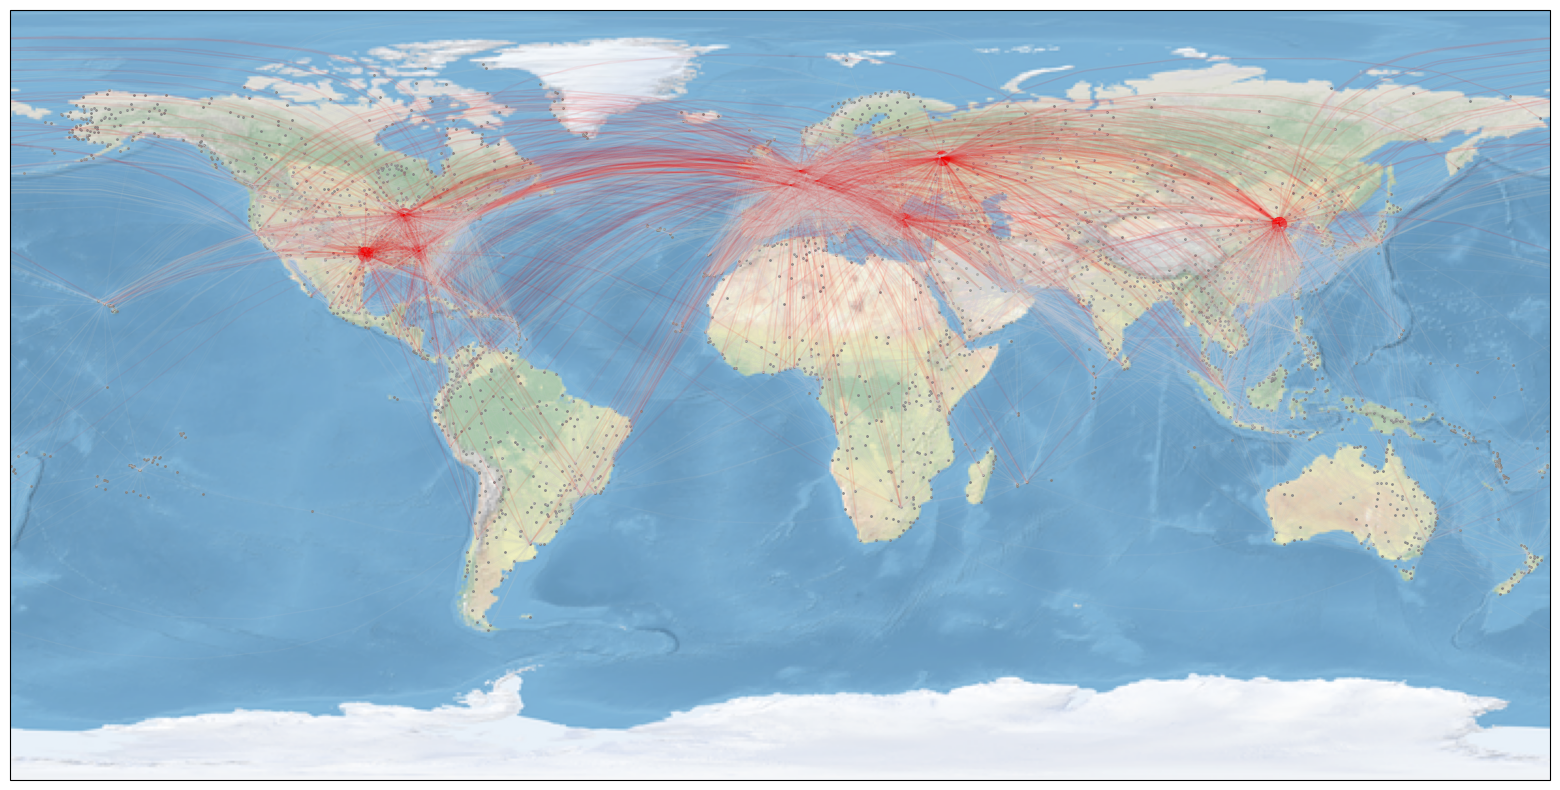

In [80]:
top10_dc = top_dc.head(10)
top_10_airport_ids = set(top10_dc['id'])

fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_global()
ax.stock_img()  

#Airports
for node, attrs in G.nodes(data=True):
    #Check if both 'lat' and 'lon' attributes exist
    if 'lon' in attrs and 'lat' in attrs:
        color = 'red' if node in top_10_airport_ids else 'grey'  #Highlight top 10 in red
        ax.plot(attrs['lon'], attrs['lat'], marker='o', color=color, markersize=10 if node in top_10_airport_ids else 1, transform=ccrs.Geodetic())


#Routes
for source, dest, attrs in G.edges(data=True):
    source_node = G.nodes[source]
    dest_node = G.nodes[dest]
        
    source_coords = (source_node['lat'], source_node['lon'])
    dest_coords = (dest_node['lat'], dest_node['lon'])

    color = 'red' if source in top_10_airport_ids or dest in top_10_airport_ids else 'lightgrey'
    ax.plot([source_coords[1], dest_coords[1]], [source_coords[0], dest_coords[0]], color=color, linewidth=30 if node in top_10_airport_ids else 1, alpha=1 if node in top_10_airport_ids else 0.05, transform=ccrs.Geodetic())

plt.show()

In [81]:
routes_connected_to_top10 = 0

for source, dest, attrs in G.edges(data=True):

    if source in top_10_airport_ids or dest in top_10_airport_ids:
        routes_connected_to_top10 += 1

print(f'{routes_connected_to_top10} operated routes out of {len(G.edges)} are either in our outlinks from the 10 largest airports in terms of degree centrality.')
print(f'This is {round((routes_connected_to_top10/len(G.edges))*100,2)}% out of all routes.')

4169 operated routes out of 36816 are either in our outlinks from the 10 largest airports in terms of degree centrality.
This is 11.32% out of all routes.


### Betweenness centrality

Which airports are the most important connectors?

In [82]:
betweenness_centrality = nx.betweenness_centrality(G)

In [83]:
top_bc = pd.DataFrame(betweenness_centrality.items())
top_bc.columns =['id', 'betweenness_centrality']
top_bc = top_bc.sort_values(by=['betweenness_centrality'], ascending=False)

top_bc['id'] = top_bc['id'].astype(str)

top_bc = pd.merge(top_bc,
                  airports,
                  on='id',
                  how='inner')

top_bc.head(10)

id  betweenness_centrality                                         name  \
0  1382                0.064090      Charles de Gaulle International Airport   
1  3484                0.062142            Los Angeles International Airport   
2  2188                0.060087                  Dubai International Airport   
3   340                0.054225                    Frankfurt am Main Airport   
4  3774                0.052764  Ted Stevens Anchorage International Airport   
5  3364                0.051084        Beijing Capital International Airport   
6  3830                0.046272         Chicago O'Hare International Airport   
7   193                0.045887      Lester B. Pearson International Airport   
8   580                0.045717                   Amsterdam Airport Schiphol   
9  1701                0.043056                Atatürk International Airport   

          city               country                      region  iso iata  \
0        Paris                France       Europe & Central Asia  FRA  CDG   
1  Los Angeles         United States               North America  USA  LAX   
2        Dubai  United Arab Emirates  Middle East & North Africa  ARE  DXB   
3    Frankfurt               Germany       Europe & Central Asia  DEU  FRA   
4    Anchorage         United States               North America  USA  ANC   
5      Beijing                 China         East Asia & Pacific  CHN  PEK   
6      Chicago         United States               North America  USA  ORD   
7      Toronto                Canada               North America  CAN  YYZ   
8    Amsterdam           Netherlands       Europe & Central Asia  NLD  AMS   
9     Istanbul                Turkey       Europe & Central Asia  TUR  ISL   

   icao        lat         lon  
0  LFPG  49.012798    2.550000  
1  KLAX  33.942501 -118.407997  
2  OMDB  25.252800   55.364399  
3  EDDF  50.033333    8.570556  
4  PANC  61.174400 -149.996002  
5  ZBAA  40.080101  116.584999  
6  KORD  41.978600  -87.904800  
7  CYYZ  43.677200  -79.630600  
8  EHAM  52.308601    4.763890  
9  LTBA  40.976898   28.814600

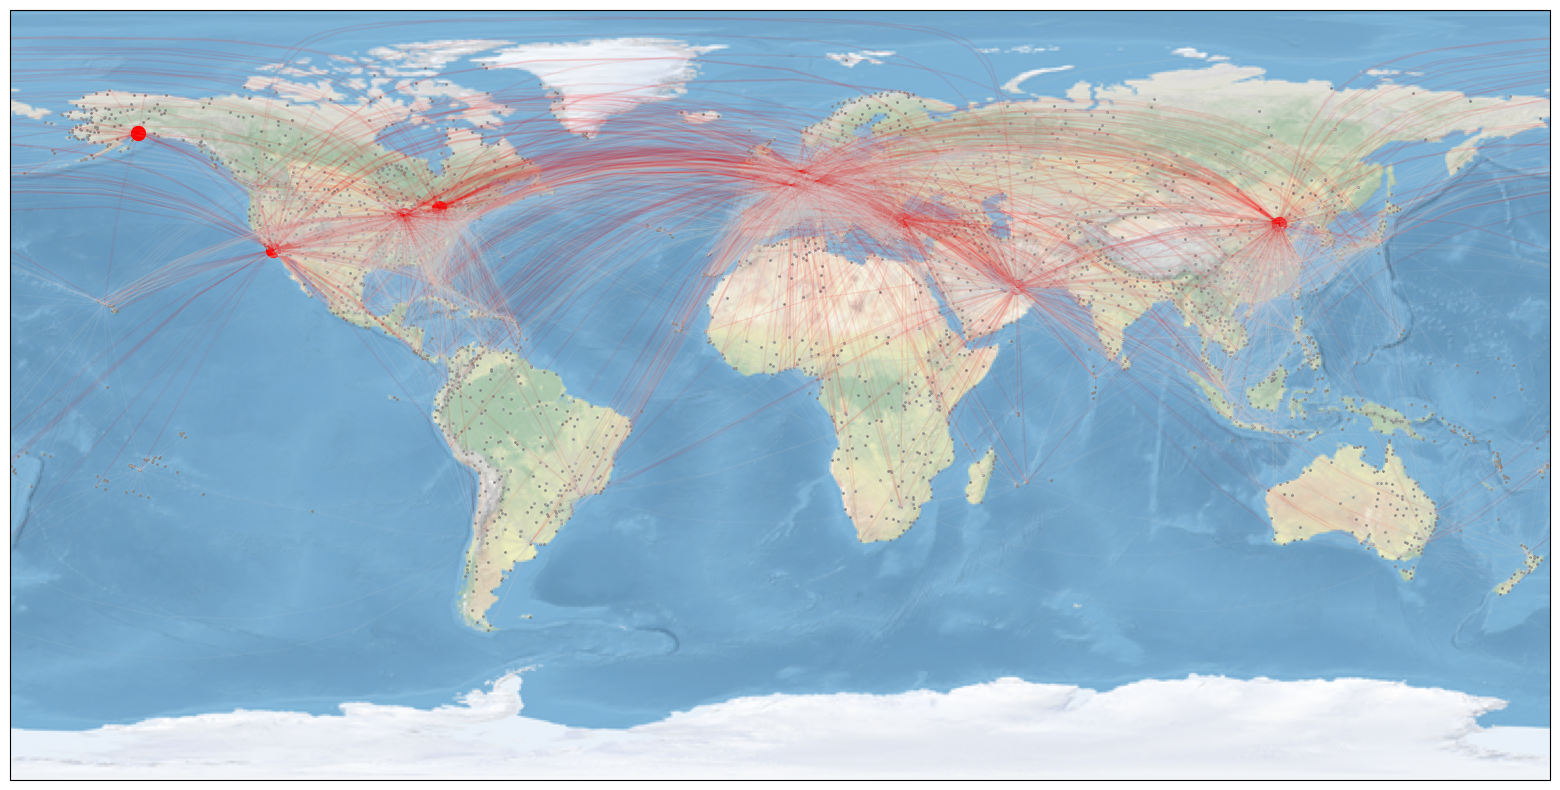

In [84]:
top10_bc = top_bc.head(10)
top_10_airport_ids = set(top10_bc['id'])

fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_global()
ax.stock_img()  

#Airports
for node, attrs in G.nodes(data=True):
    #Check if both 'lat' and 'lon' attributes exist
    if 'lon' in attrs and 'lat' in attrs:
        color = 'red' if node in top_10_airport_ids else 'grey'  #Highlight top 10 in red
        ax.plot(attrs['lon'], attrs['lat'], marker='o', color=color, markersize=10 if node in top_10_airport_ids else 1, transform=ccrs.Geodetic())


#Routes
for source, dest, attrs in G.edges(data=True):
    source_node = G.nodes[source]
    dest_node = G.nodes[dest]
        
    source_coords = (source_node['lat'], source_node['lon'])
    dest_coords = (dest_node['lat'], dest_node['lon'])

    color = 'red' if source in top_10_airport_ids or dest in top_10_airport_ids else 'lightgrey'
    ax.plot([source_coords[1], dest_coords[1]], [source_coords[0], dest_coords[0]], color=color, linewidth=30 if node in top_10_airport_ids else 1, alpha=1 if node in top_10_airport_ids else 0.05, transform=ccrs.Geodetic())

plt.show()

In [85]:
routes_connected_to_top10 = 0

for source, dest, attrs in G.edges(data=True):

    if source in top_10_airport_ids or dest in top_10_airport_ids:
        routes_connected_to_top10 += 1

print(f'{routes_connected_to_top10} operated routes out of {len(G.edges)} are either in our outlinks from the 10 largest airports in terms of betweenness centrality.')
print(f'This is {round((routes_connected_to_top10/len(G.edges))*100,2)}% out of all routes.')

3622 operated routes out of 36816 are either in our outlinks from the 10 largest airports in terms of betweenness centrality.
This is 9.84% out of all routes.


### Weighted degree centrality

Routes or edges weighted by the visa.

In [86]:
degree_unweighted = G.degree()
degree_unweighted = dict(degree_unweighted)
degree_unweighted = pd.DataFrame(degree_unweighted.items())

In [87]:
degree_unweighted[1].mean()

23.397521448999047

In [88]:
degree = G.degree(weight='visa')
degree_dict = dict(degree)
max_degree = max(degree_dict.values())
min_degree = min(degree_dict.values())

degree_centrality_weighted = {node: deg/max_degree for node, deg in degree_dict.items()}

#The most influential node, meaning the node that has the most connections with the highest visa score
most_influential_node = [node for node, centrality in degree_centrality_weighted.items() if centrality == 1]

#Least influential nodes in that sense

least_influential_nodes = [node for node, centrality in degree_centrality_weighted.items() if centrality == min_degree/max_degree]

In [89]:
G.nodes[most_influential_node[0]]

{'name': 'Denver International Airport',
 'city': 'Denver',
 'country': 'United States',
 'region': 'North America',
 'iso': 'USA',
 'iata': 'DEN',
 'icao': 'KDEN',
 'lat': 39.861698150635,
 'lon': -104.672996521}

In [90]:
top_wdc = pd.DataFrame(degree_centrality_weighted.items())
top_wdc.columns =['id', 'degree_centrality']
top_wdc = top_wdc.sort_values(by=['degree_centrality'], ascending=False)

top_wdc['id'] = top_wdc['id'].astype(str)

top_wdc = pd.merge(top_wdc,
                  airports,
                  on='id',
                  how='inner')


In [91]:
top_wdc.head(10)

id  degree_centrality                                               name  \
0  3751           1.000000                       Denver International Airport   
1   346           0.993827                                     Munich Airport   
2  1218           0.901235                    Barcelona International Airport   
3  1701           0.876543                      Atatürk International Airport   
4  1229           0.814815               Adolfo Suárez Madrid–Barajas Airport   
5  1555           0.790123                Leonardo da Vinci–Fiumicino Airport   
6  3877           0.787037                     McCarran International Airport   
7  3858           0.783951  Minneapolis-St Paul International/Wold-Chamber...   
8  3998           0.762346                          Palma De Mallorca Airport   
9   302           0.731481                                   Brussels Airport   

                city        country                 region  iso iata  icao  \
0             Denver  United States          North America  USA  DEN  KDEN   
1             Munich        Germany  Europe & Central Asia  DEU  MUC  EDDM   
2          Barcelona          Spain  Europe & Central Asia  ESP  BCN  LEBL   
3           Istanbul         Turkey  Europe & Central Asia  TUR  ISL  LTBA   
4             Madrid          Spain  Europe & Central Asia  ESP  MAD  LEMD   
5               Rome          Italy  Europe & Central Asia  ITA  FCO  LIRF   
6          Las Vegas  United States          North America  USA  LAS  KLAS   
7        Minneapolis  United States          North America  USA  MSP  KMSP   
8  Palma de Mallorca          Spain  Europe & Central Asia  ESP  PMI  LEPA   
9           Brussels        Belgium  Europe & Central Asia  BEL  BRU  EBBR   

         lat         lon  
0  39.861698 -104.672997  
1  48.353802   11.786100  
2  41.297100    2.078460  
3  40.976898   28.814600  
4  40.471926   -3.562640  
5  41.800278   12.238889  
6  36.080101 -115.152000  
7  44.882000  -93.221802  
8  39.551701    2.738810  
9  50.901402    4.484440

Where are the least influential airports located?

In [92]:
from collections import Counter

country_counter = Counter()

for node in least_influential_nodes:
    country = G.nodes[node].get('country', 'Unknown')
    country_counter[country] += 1

for country, count in country_counter.items():
    print(f"{country}: {count}")

Italy: 1
Czech Republic: 2
Turkmenistan: 1
North Korea: 1
South Korea: 1


### Eigenvector centrality

In [93]:
pagerank = nx.pagerank(G, alpha=0.95) 
pagerank_centralities = np.array(list(pagerank.values()))
max_centrality = pagerank_centralities.max()
min_centrality = pagerank_centralities.min()

print(f"Maximum centrality value: {max_centrality:.3f}")
print(f"Minimum centrality value: {min_centrality:.3f}")

max_node = max(pagerank, key=pagerank.get)
max_value = pagerank[max_node]

min_node = min(pagerank, key=pagerank.get)
min_value = pagerank[min_node]

Maximum centrality value: 0.006
Minimum centrality value: 0.000


In [94]:
G.nodes[max_node]

{'name': 'Hartsfield Jackson Atlanta International Airport',
 'city': 'Atlanta',
 'country': 'United States',
 'region': 'North America',
 'iso': 'USA',
 'iata': 'ATL',
 'icao': 'KATL',
 'lat': 33.6367,
 'lon': -84.428101}

In [95]:
G.nodes[min_node]

{'name': 'Matari Airport',
 'city': 'Isiro',
 'country': 'Congo (Kinshasa)',
 'region': 'Sub-Saharan Africa',
 'iso': 'COD',
 'iata': 'IRP',
 'icao': 'FZJH',
 'lat': 2.8276100158691406,
 'lon': 27.588300704956055}

In [96]:
top_pagerank = pd.DataFrame(pagerank.items())
top_pagerank.columns =['id', 'pagerank']
top_pagerank = top_pagerank.sort_values(by=['pagerank'], ascending=False)

top_pagerank['id'] = top_pagerank['id'].astype(str)

top_pagerank = pd.merge(top_pagerank,
                  airports,
                  on='id',
                  how='inner')

top_pagerank.head(10)

id  pagerank                                              name  \
0  3682  0.005523  Hartsfield Jackson Atlanta International Airport   
1  1701  0.005156                     Atatürk International Airport   
2  3830  0.005139              Chicago O'Hare International Airport   
3   340  0.005130                         Frankfurt am Main Airport   
4  1382  0.005122           Charles de Gaulle International Airport   
5   580  0.004890                        Amsterdam Airport Schiphol   
6  3670  0.004805           Dallas Fort Worth International Airport   
7  3364  0.004719             Beijing Capital International Airport   
8  3751  0.004572                      Denver International Airport   
9  4029  0.004385                  Domodedovo International Airport   

                city        country                 region  iso iata  icao  \
0            Atlanta  United States          North America  USA  ATL  KATL   
1           Istanbul         Turkey  Europe & Central Asia  TUR  ISL  LTBA   
2            Chicago  United States          North America  USA  ORD  KORD   
3          Frankfurt        Germany  Europe & Central Asia  DEU  FRA  EDDF   
4              Paris         France  Europe & Central Asia  FRA  CDG  LFPG   
5          Amsterdam    Netherlands  Europe & Central Asia  NLD  AMS  EHAM   
6  Dallas-Fort Worth  United States          North America  USA  DFW  KDFW   
7            Beijing          China    East Asia & Pacific  CHN  PEK  ZBAA   
8             Denver  United States          North America  USA  DEN  KDEN   
9             Moscow         Russia  Europe & Central Asia  RUS  DME  UUDD   

         lat         lon  
0  33.636700  -84.428101  
1  40.976898   28.814600  
2  41.978600  -87.904800  
3  50.033333    8.570556  
4  49.012798    2.550000  
5  52.308601    4.763890  
6  32.896801  -97.038002  
7  40.080101  116.584999  
8  39.861698 -104.672997  
9  55.408798   37.906300

#### Eigenvector centrality for reference

In [97]:
eigenvector_centrality = nx.eigenvector_centrality_numpy(G)

In [98]:
eig_centralities = np.array(list(eigenvector_centrality.values()))
max_centrality = eig_centralities.max()
min_centrality = eig_centralities.min()

print(f"Maximum centrality value: {max_centrality:.3f}")
print(f"Minimum centrality value: {min_centrality:.3f}")

Maximum centrality value: 0.166
Minimum centrality value: 0.000


In [99]:
max_node = max(eigenvector_centrality, key=eigenvector_centrality.get)
max_value = eigenvector_centrality[max_node]

min_node = min(eigenvector_centrality, key=eigenvector_centrality.get)
min_value = eigenvector_centrality[min_node]

In [100]:
G.nodes[max_node]

{'name': 'Amsterdam Airport Schiphol',
 'city': 'Amsterdam',
 'country': 'Netherlands',
 'region': 'Europe & Central Asia',
 'iso': 'NLD',
 'iata': 'AMS',
 'icao': 'EHAM',
 'lat': 52.308601,
 'lon': 4.76389}

In [101]:
G.nodes[min_node]

{'name': 'Peawanuck Airport',
 'city': 'Peawanuck',
 'country': 'Canada',
 'region': 'North America',
 'iso': 'CAN',
 'iata': 'YPO',
 'icao': 'CYPO',
 'lat': 54.98809814453125,
 'lon': -85.44329833984375}

In [102]:
top_ec = pd.DataFrame(eigenvector_centrality.items())
top_ec.columns =['id', 'eigenvector_centrality']
top_ec = top_ec.sort_values(by=['eigenvector_centrality'], ascending=False)

top_ec['id'] = top_ec['id'].astype(str)

top_ec = pd.merge(top_ec,
                  airports,
                  on='id',
                  how='inner')

top_ec.head(10)

id  eigenvector_centrality                                     name  \
0   580                0.165998               Amsterdam Airport Schiphol   
1   340                0.165797                Frankfurt am Main Airport   
2  1382                0.159275  Charles de Gaulle International Airport   
3   346                0.149050                           Munich Airport   
4   507                0.136864                  London Heathrow Airport   
5  1555                0.135929      Leonardo da Vinci–Fiumicino Airport   
6  1218                0.129552          Barcelona International Airport   
7  1701                0.129524            Atatürk International Airport   
8  1678                0.126264                           Zürich Airport   
9  1229                0.123331     Adolfo Suárez Madrid–Barajas Airport   

        city         country                 region  iso iata  icao  \
0  Amsterdam     Netherlands  Europe & Central Asia  NLD  AMS  EHAM   
1  Frankfurt         Germany  Europe & Central Asia  DEU  FRA  EDDF   
2      Paris          France  Europe & Central Asia  FRA  CDG  LFPG   
3     Munich         Germany  Europe & Central Asia  DEU  MUC  EDDM   
4     London  United Kingdom  Europe & Central Asia  GBR  LHR  EGLL   
5       Rome           Italy  Europe & Central Asia  ITA  FCO  LIRF   
6  Barcelona           Spain  Europe & Central Asia  ESP  BCN  LEBL   
7   Istanbul          Turkey  Europe & Central Asia  TUR  ISL  LTBA   
8     Zurich     Switzerland  Europe & Central Asia  CHE  ZRH  LSZH   
9     Madrid           Spain  Europe & Central Asia  ESP  MAD  LEMD   

         lat        lon  
0  52.308601   4.763890  
1  50.033333   8.570556  
2  49.012798   2.550000  
3  48.353802  11.786100  
4  51.470600  -0.461941  
5  41.800278  12.238889  
6  41.297100   2.078460  
7  40.976898  28.814600  
8  47.464699   8.549170  
9  40.471926  -3.562640

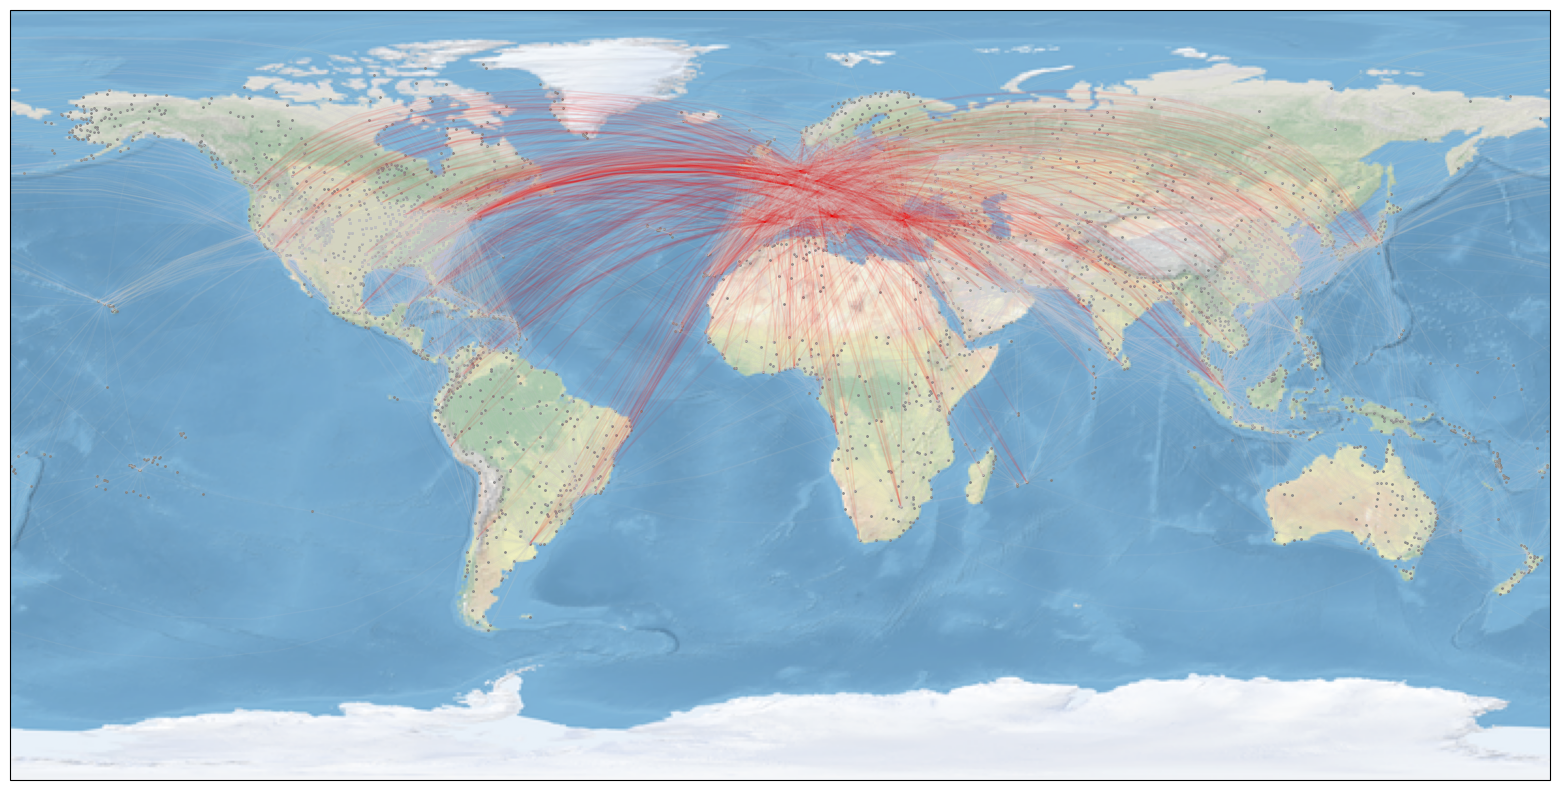

In [103]:
top10_ec = top_ec.head(10)
top_10_airport_ids = set(top10_ec['id'])

fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_global()
ax.stock_img()  

#Airports
for node, attrs in G.nodes(data=True):
    #Check if both 'lat' and 'lon' attributes exist
    if 'lon' in attrs and 'lat' in attrs:
        color = 'red' if node in top_10_airport_ids else 'grey'  #Highlight top 10 in red
        ax.plot(attrs['lon'], attrs['lat'], marker='o', color=color, markersize=10 if node in top_10_airport_ids else 1, transform=ccrs.Geodetic())


#Routes
for source, dest, attrs in G.edges(data=True):
    source_node = G.nodes[source]
    dest_node = G.nodes[dest]
        
    source_coords = (source_node['lat'], source_node['lon'])
    dest_coords = (dest_node['lat'], dest_node['lon'])

    color = 'red' if source in top_10_airport_ids or dest in top_10_airport_ids else 'lightgrey'
    ax.plot([source_coords[1], dest_coords[1]], [source_coords[0], dest_coords[0]], color=color, linewidth=30 if node in top_10_airport_ids else 1, alpha=1 if node in top_10_airport_ids else 0.05, transform=ccrs.Geodetic())

plt.show()

In [104]:
routes_connected_to_top10 = 0

for source, dest, attrs in G.edges(data=True):

    if source in top_10_airport_ids or dest in top_10_airport_ids:
        routes_connected_to_top10 += 1

print(f'{routes_connected_to_top10} operated routes out of {len(G.edges)} are either in our outlinks from the 10 largest airports in terms of eigenvector centrality.')
print(f'This is {round((routes_connected_to_top10/len(G.edges))*100,2)}% out of all routes.')

3719 operated routes out of 36816 are either in our outlinks from the 10 largest airports in terms of eigenvector centrality.
This is 10.1% out of all routes.


## Community detection

In [105]:
#Get region to each node and see if the communities form in regions

#Create a mapping from country to region
country_to_region = dict(zip(geo_df['Country Code'], geo_df['Region']))

#Update the nodes in the graph with the region attribute
for node in G.nodes:
    country = G.nodes[node].get('iso')
    if country in country_to_region:
        G.nodes[node]['region'] = country_to_region[country]
    else:
        G.nodes[node]['region'] = 'Unknown' #Some airports are located within "countries" that are not in the UN list

In [106]:
#The "unknown" region
node_data = []
for node, data in G.nodes(data=True):
    node_data.append({'node_id': node, **data})

nodes_df = pd.DataFrame(node_data)
nodes_df.loc[nodes_df['region'] == "Unknown", 'country'].unique()

array(['Greenland', 'Guernsey', 'Jersey', 'Isle of Man',
       'Falkland Islands', 'Faroe Islands', 'Mayotte', 'Reunion',
       'Saint Pierre and Miquelon', 'Gibraltar',
       'Turks and Caicos Islands', 'Cayman Islands', 'Cook Islands',
       'American Samoa', 'French Polynesia', 'Wallis and Futuna',
       'New Caledonia', 'Northern Mariana Islands', 'Guam', 'Taiwan',
       'French Guiana', 'Martinique', 'Guadeloupe', 'Virgin Islands',
       'Puerto Rico', 'Aruba', 'Netherlands Antilles', 'Anguilla',
       'Christmas Island', 'Norfolk Island', 'Bermuda', 'Western Sahara',
       'Cocos (Keeling) Islands'], dtype=object)

In [107]:
#Assigning these airports manually a region label

manual_region_mapping = {
    'Greenland': 'Europe & Central Asia',
    'Guernsey': 'Europe & Central Asia',
    'Jersey': 'Europe & Central Asia',
    'Isle of Man': 'Europe & Central Asia',
    'Falkland Islands': 'Latin America & Caribbean',
    'Faroe Islands': 'Europe & Central Asia',
    'Mayotte': 'Sub-Saharan Africa',
    'Reunion': 'Sub-Saharan Africa',
    'Saint Pierre and Miquelon': 'Latin America & Caribbean',
    'Gibraltar': 'Europe & Central Asia',
    'Turks and Caicos Islands': 'Latin America & Caribbean',
    'Cayman Islands': 'Latin America & Caribbean',
    'Cook Islands': 'SEast Asia & Pacific',
    'American Samoa': 'East Asia & Pacific',
    'French Polynesia': 'East Asia & Pacific',
    'Wallis and Futuna': 'East Asia & Pacific',
    'New Caledonia': 'East Asia & Pacific',
    'Northern Mariana Islands': 'East Asia & Pacific',
    'Guam': 'East Asia & Pacific',
    'Taiwan': 'South Asia',
    'French Guiana': 'Latin America & Caribbean',
    'Martinique': 'Latin America & Caribbean',
    'Guadeloupe': 'Latin America & Caribbean',
    'Virgin Islands': 'Latin America & Caribbean',
    'Puerto Rico': 'Latin America & Caribbean',
    'Aruba': 'Latin America & Caribbean',
    'Netherlands Antilles': 'Latin America & Caribbean',
    'Anguilla': 'Latin America & Caribbean',
    'British Virgin Islands': 'Latin America & Caribbean',
    'Kyrgyzstan': 'Europe & Central Asia',
    'Christmas Island': 'East Asia & Pacific',
    'Norfolk Island': 'East Asia & Pacific',
    'Bermuda': 'Latin America & Caribbean',
    'Western Sahara': 'Middle East & North Africa',
    'Cocos (Keeling) Islands': 'East Asia & Pacific'
}

for node in G.nodes:
    country = G.nodes[node].get('country')
    if country in manual_region_mapping:
        G.nodes[node]['region'] = manual_region_mapping[country]
    elif G.nodes[node].get('region') == 'Unknown':
        G.nodes[node]['region'] = 'Unknown'

Detecting communities with different algorithms

In [108]:
from networkx.algorithms import community
from infomap import Infomap
from networkx.algorithms.community import asyn_lpa_communities

#Greedy
communities_greedy = community.greedy_modularity_communities(G)

#Infomap
node_to_id = {node: i for i, node in enumerate(G.nodes())}
id_to_node = {i: node for node, i in node_to_id.items()}

infomap = Infomap()

for source, target in G.edges():
    infomap.addLink(node_to_id[source], node_to_id[target])

infomap.run()

communities_info = infomap.get_modules()
community_list_info = {}
for node_id, module in communities_info.items():
    node = id_to_node[node_id]
    if module not in community_list_info:
        community_list_info[module] = []
    community_list_info[module].append(node)

#Label Propagation 
communities_lpa = asyn_lpa_communities(G, weight='weight')
community_list_lpa = {i: list(community) for i, community in enumerate(communities_lpa)}

#### Greedy algorithm

In [109]:
#Greedy
for i, community in enumerate(communities_greedy):
    print(f"Community {i}:")
    region_count = {}
    for node in community:
        region = G.nodes[node].get("region")
        if region not in region_count:
            region_count[region] = 0
        region_count[region] += 1
    for region, count in region_count.items():
        print(f"  {region}: {count} nodes")
    print(f'Total nodes: {len(community)}')
    print("---")

Community 0:
  East Asia & Pacific: 619 nodes
  South Asia: 133 nodes
  Europe & Central Asia: 15 nodes
  Middle East & North Africa: 105 nodes
  Sub-Saharan Africa: 54 nodes
  North America: 1 nodes
Total nodes: 927
---
Community 1:
  Latin America & Caribbean: 420 nodes
  North America: 484 nodes
  Europe & Central Asia: 1 nodes
  East Asia & Pacific: 2 nodes
Total nodes: 907
---
Community 2:
  Sub-Saharan Africa: 81 nodes
  Europe & Central Asia: 472 nodes
  Middle East & North Africa: 58 nodes
Total nodes: 611
---
Community 3:
  Europe & Central Asia: 132 nodes
Total nodes: 132
---
Community 4:
  North America: 116 nodes
Total nodes: 116
---
Community 5:
  North America: 96 nodes
Total nodes: 96
---
Community 6:
  Sub-Saharan Africa: 46 nodes
Total nodes: 46
---
Community 7:
  East Asia & Pacific: 27 nodes
  SEast Asia & Pacific: 6 nodes
  Latin America & Caribbean: 1 nodes
Total nodes: 34
---
Community 8:
  Europe & Central Asia: 25 nodes
Total nodes: 25
---
Community 9:
  Latin A

In [110]:
#Sort communities by size and take the top 5
top_communities = sorted(communities_greedy, key=len, reverse=True)[:5]

#Create a color map for the top 5 communities
colors = ['red', 'blue', 'green', 'purple', 'orange']
community_colors = {node: colors[i] for i, community in enumerate(top_communities) for node in community}

In [111]:
node_data = []
for node in G.nodes:
    data = G.nodes[node]
    if 'lat' in data and 'lon' in data:
        node_data.append({
            'node_id': node,
            'lat': data['lat'],
            'lon': data['lon'],
            'color': community_colors.get(node, 'gray')  #Default to gray if not in top communities
        })

nodes_df = pd.DataFrame(node_data)

C:\Users\annilo\AppData\Local\Temp\ipykernel_29444\659797006.py:3: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


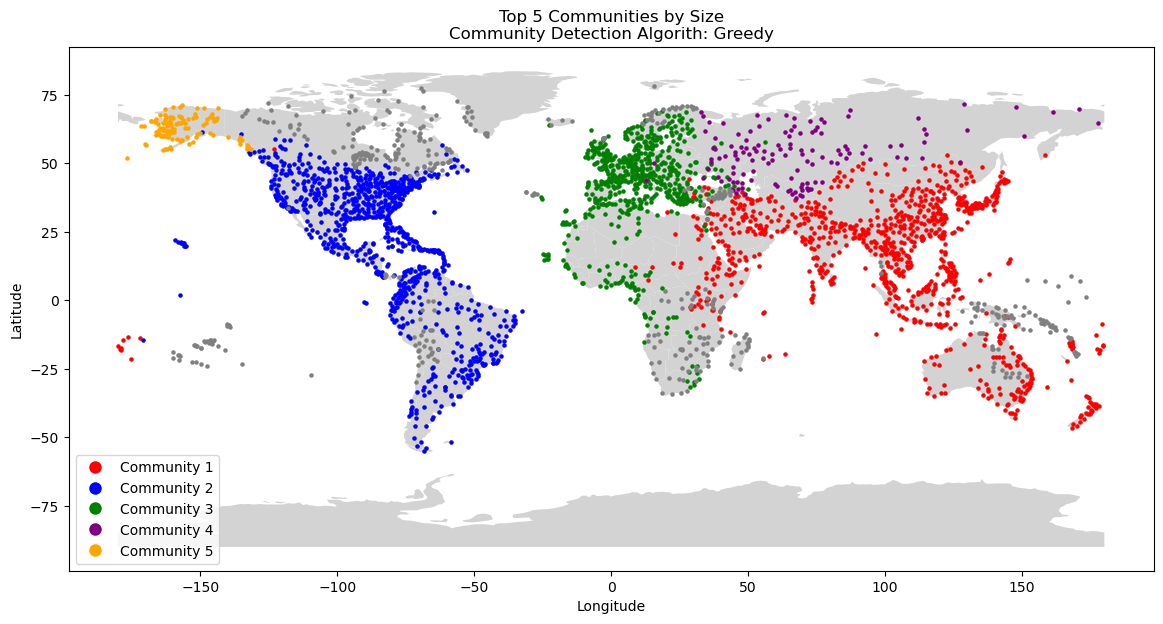

In [112]:
from matplotlib.lines import Line2D

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

#Create a GeoDataFrame for the nodes
gdf = gpd.GeoDataFrame(nodes_df, geometry=gpd.points_from_xy(nodes_df.lon, nodes_df.lat))

fig, ax = plt.subplots(1, 1, figsize=(14, 10))
world.plot(ax=ax, color='lightgray')

for color in colors:
    community_gdf = gdf[gdf['color'] == color]
    community_gdf.plot(ax=ax, color=color, markersize=5, label=f'Community {colors.index(color) + 1}')

remaining_gdf = gdf[gdf['color'] == 'gray']
if not remaining_gdf.empty:
    remaining_gdf.plot(ax=ax, color='gray', markersize=5, label='Other nodes')

legend_handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=f'Community {i + 1}')
                  for i, color in enumerate(colors)]

ax.legend(handles=legend_handles, title="")
plt.title('Top 5 Communities by Size\nCommunity Detection Algorith: Greedy')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

#### Infomap

In [113]:
#Infomap
for module, nodes in community_list_info.items():
    print(f"Community {module}:")
    region_count = {}
    for node in nodes:
        region = G.nodes[node].get("region")
        if region not in region_count:
            region_count[region] = 0
        region_count[region] += 1
    for region, count in region_count.items():
        print(f"  {region}: {count} nodes")
    print(f'Total nodes: {len(nodes)}')
    print("---")

Community 3:
  East Asia & Pacific: 256 nodes
  SEast Asia & Pacific: 6 nodes
  Latin America & Caribbean: 1 nodes
Total nodes: 263
---
Community 1:
  Europe & Central Asia: 707 nodes
  North America: 563 nodes
  Latin America & Caribbean: 454 nodes
  Middle East & North Africa: 166 nodes
  Sub-Saharan Africa: 216 nodes
  South Asia: 124 nodes
  East Asia & Pacific: 2 nodes
Total nodes: 2232
---
Community 4:
  North America: 116 nodes
Total nodes: 116
---
Community 5:
  North America: 49 nodes
Total nodes: 49
---
Community 2:
  East Asia & Pacific: 477 nodes
  South Asia: 9 nodes
  North America: 1 nodes
Total nodes: 487
---


In [114]:
#Sort communities by size 
top_communities = sorted(community_list_info.items(), key=lambda x: len(x[1]), reverse=True)

#Create a color map for the 4 communities
colors = ['red', 'blue', 'green', 'orange','yellow']
community_colors = {node: colors[i] for i, (community, nodes) in enumerate(top_communities) for node in nodes}

In [115]:
node_data = []
for node in G.nodes:
    data = G.nodes[node]
    if 'lat' in data and 'lon' in data:
        node_data.append({
            'node_id': node,
            'lat': data['lat'],
            'lon': data['lon'],
            'color': community_colors.get(node, 'gray')  #Default to gray if not in top communities
        })

nodes_df = pd.DataFrame(node_data)

C:\Users\annilo\AppData\Local\Temp\ipykernel_29444\2285741115.py:3: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


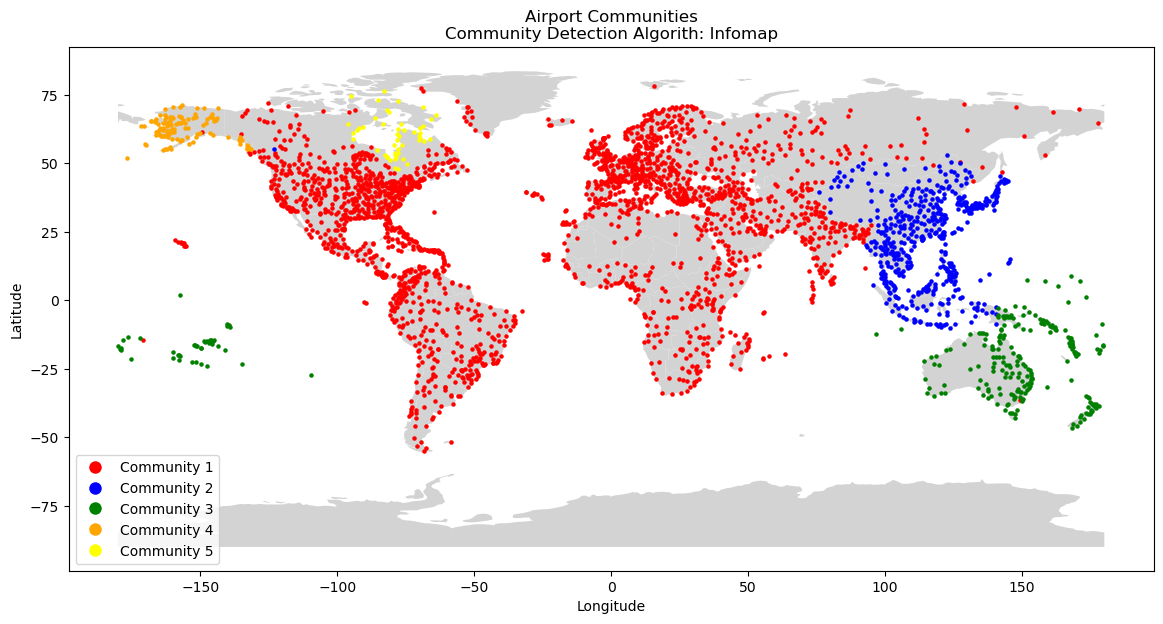

In [116]:
from matplotlib.lines import Line2D

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

#Create a GeoDataFrame for the nodes
gdf = gpd.GeoDataFrame(nodes_df, geometry=gpd.points_from_xy(nodes_df.lon, nodes_df.lat))

fig, ax = plt.subplots(1, 1, figsize=(14, 10))
world.plot(ax=ax, color='lightgray')

for color in colors:
    community_gdf = gdf[gdf['color'] == color]
    community_gdf.plot(ax=ax, color=color, markersize=5, label=f'Community {colors.index(color) + 1}')

legend_handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=f'Community {i + 1}')
                  for i, color in enumerate(colors)]

ax.legend(handles=legend_handles, title="")
plt.title('Airport Communities\nCommunity Detection Algorith: Infomap')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

#### Leiden Propagation Algorithm

In [117]:
#LPA
for module, nodes in community_list_lpa.items():
    print(f"Community {module}:")
    region_count = {}
    for node in nodes:
        region = G.nodes[node].get("region")
        if region not in region_count:
            region_count[region] = 0
        region_count[region] += 1
    for region, count in region_count.items():
        print(f"  {region}: {count} nodes")
    print(f'Total nodes: {len(nodes)}')
    print("---")

Community 0:
  East Asia & Pacific: 23 nodes
Total nodes: 23
---
Community 1:
  Europe & Central Asia: 6 nodes
Total nodes: 6
---
Community 2:
  Europe & Central Asia: 4 nodes
Total nodes: 4
---
Community 3:
  Europe & Central Asia: 3 nodes
Total nodes: 3
---
Community 4:
  Europe & Central Asia: 4 nodes
Total nodes: 4
---
Community 5:
  North America: 18 nodes
Total nodes: 18
---
Community 6:
  Sub-Saharan Africa: 157 nodes
  Europe & Central Asia: 650 nodes
  South Asia: 96 nodes
  Middle East & North Africa: 152 nodes
Total nodes: 1055
---
Community 7:
  Latin America & Caribbean: 232 nodes
  North America: 472 nodes
  Europe & Central Asia: 1 nodes
  East Asia & Pacific: 2 nodes
Total nodes: 707
---
Community 8:
  North America: 2 nodes
Total nodes: 2
---
Community 9:
  North America: 6 nodes
Total nodes: 6
---
Community 10:
  North America: 11 nodes
Total nodes: 11
---
Community 11:
  North America: 3 nodes
Total nodes: 3
---
Community 12:
  Latin America & Caribbean: 2 nodes
Tota

In [118]:
#Sort communities by size and take the top 5
top_communities = sorted(community_list_lpa.items(), key=lambda x: len(x[1]), reverse=True)[:5]

#Create a color map for the 5 communities
colors = ['red', 'blue', 'green', 'purple','orange']
community_colors = {node: colors[i] for i, (community, nodes) in enumerate(top_communities) for node in nodes}

In [119]:
node_data = []
for node in G.nodes:
    data = G.nodes[node]
    if 'lat' in data and 'lon' in data:
        node_data.append({
            'node_id': node,
            'lat': data['lat'],
            'lon': data['lon'],
            'color': community_colors.get(node, 'gray')  #Default to gray if not in top communities
        })

nodes_df = pd.DataFrame(node_data)

C:\Users\annilo\AppData\Local\Temp\ipykernel_29444\1480056842.py:3: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


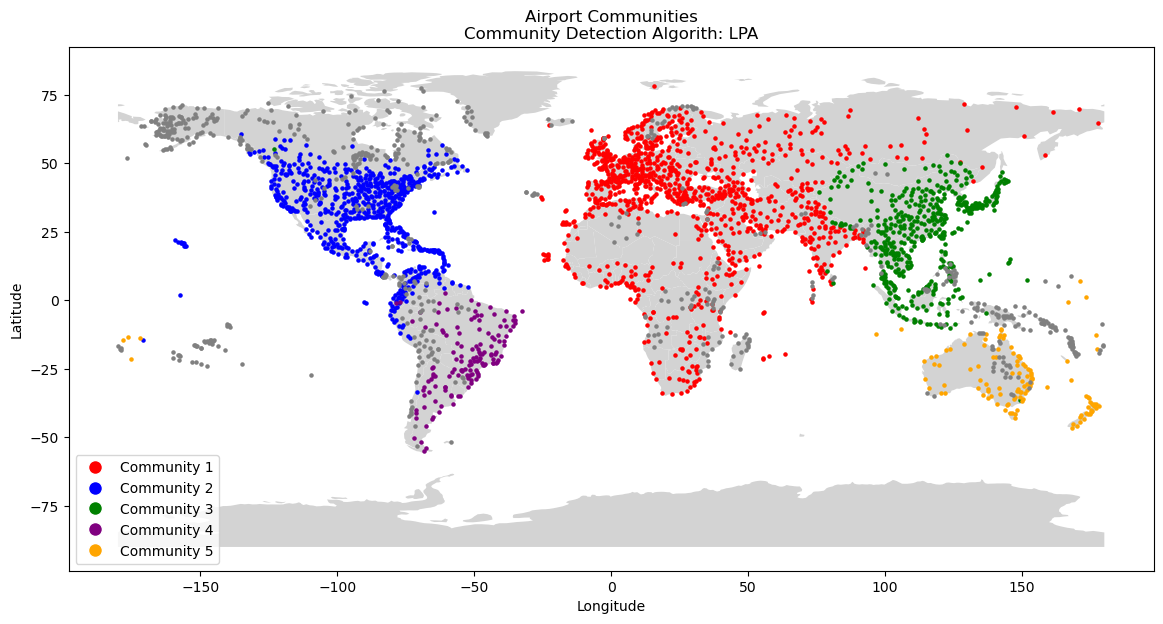

In [120]:
from matplotlib.lines import Line2D

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

#Create a GeoDataFrame for the nodes
gdf = gpd.GeoDataFrame(nodes_df, geometry=gpd.points_from_xy(nodes_df.lon, nodes_df.lat))

fig, ax = plt.subplots(1, 1, figsize=(14, 10))
world.plot(ax=ax, color='lightgray')

for color in colors:
    community_gdf = gdf[gdf['color'] == color]
    community_gdf.plot(ax=ax, color=color, markersize=5, label=f'Community {colors.index(color) + 1}')

remaining_gdf = gdf[gdf['color'] == 'gray']
if not remaining_gdf.empty:
    remaining_gdf.plot(ax=ax, color='gray', markersize=5, label='Other nodes')


legend_handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=f'Community {i + 1}')
                  for i, color in enumerate(colors)]

ax.legend(handles=legend_handles, title="")
plt.title('Airport Communities\nCommunity Detection Algorith: LPA')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

### Country-level analysis

Creating fictional graph with routes that are based on all the routes originating from the countries.

In [121]:
routes_country = routes.copy()

In [122]:
airports['id'] = airports['id'].astype(int)

routes_country = pd.merge(routes,
                  airports[['id', 'iso']],
                  left_on='source', right_on = 'id',
                  how='inner').drop(columns='id').rename(columns={'iso':'source_iso'})

routes_country = pd.merge(routes_country,
                  airports[['id', 'iso']],
                  left_on='destination', right_on = 'id',
                  how='inner').drop(columns='id').rename(columns={'iso':'destination_iso'})

In [125]:
grouped_routes = routes_country.groupby(['source_iso', 'destination_iso']).agg(
    visa=('visa', 'max'),
    route_count=('visa', 'size')
).reset_index()

In [126]:
country_routes = grouped_routes[grouped_routes['source_iso'] != grouped_routes['destination_iso']] #Removing within-country flights
country_routes = country_routes[~country_routes['destination_iso'].isna()]

In [127]:
country_routes

source_iso destination_iso  visa  route_count
1           AFG             ARE   0.0            3
2           AFG             AZE   0.0            1
3           AFG             IND   0.0            3
4           AFG             IRN   0.0            5
5           AFG             KWT   0.0            1
...         ...             ...   ...          ...
4314        ZWE             MWI   1.0            1
4315        ZWE             NAM   1.0            2
4316        ZWE             TZA   1.0            1
4317        ZWE             ZAF   1.0            4
4318        ZWE             ZMB   1.0            1

[4196 rows x 4 columns]

In [128]:
country_routes = country_routes.merge(geo_df[['2014', '2022','Country Code','OF Country Name','Region']], 
                                      how='left', 
                                      left_on='source_iso', 
                                      right_on='Country Code')

In [129]:
country_routes.head()

source_iso destination_iso  visa  route_count        2014        2022  \
0        AFG             ARE   0.0            3  32716210.0  41128771.0   
1        AFG             AZE   0.0            1  32716210.0  41128771.0   
2        AFG             IND   0.0            3  32716210.0  41128771.0   
3        AFG             IRN   0.0            5  32716210.0  41128771.0   
4        AFG             KWT   0.0            1  32716210.0  41128771.0   

  Country Code OF Country Name      Region  
0          AFG     Afghanistan  South Asia  
1          AFG     Afghanistan  South Asia  
2          AFG     Afghanistan  South Asia  
3          AFG     Afghanistan  South Asia  
4          AFG     Afghanistan  South Asia

Creating the country graph

In [143]:
G_c = nx.DiGraph()

#Add edges with attributes from the dataframe
for _, row in country_routes.iterrows():
    G_c.add_node(row["source_iso"], name = row['OF Country Name'], region = row['Region'])

    G_c.add_edge(
        row['source_iso'], 
        row['destination_iso'], 
        visa=row['visa'], 
        route_count=row['route_count']
    )

In [144]:
scc = list(nx.strongly_connected_components(G_c))

largest_scc = max(scc, key=len)

G_scc = G_c.subgraph(largest_scc).copy()

Weighted degree centrality based on visa restrictions

In [145]:
degree = G_scc.degree(weight='visa')
degree_dict = dict(degree)
max_degree = max(degree_dict.values())
min_degree = min(degree_dict.values())

degree_centrality_weighted = {node: deg/max_degree for node, deg in degree_dict.items()}

least_restricted_countries = [node for node, centrality in degree_centrality_weighted.items() if centrality == 1] 
most_restricted_countries = [node for node, centrality in degree_centrality_weighted.items() if centrality == min_degree/max_degree]

In [146]:
for i in range(len(least_restricted_countries)): #Least restricted
    print(G_scc.nodes[least_restricted_countries[i]]) 

{'name': 'Germany', 'region': 'Europe & Central Asia'}


In [147]:
for i in range(len(most_restricted_countries)): #Most restricted
    print(G_scc.nodes[most_restricted_countries[i]])

{'name': 'Afghanistan', 'region': 'South Asia'}
{'name': 'Turkmenistan', 'region': 'Europe & Central Asia'}
{'name': 'North Korea', 'region': 'East Asia & Pacific'}


#### PageRank

In [152]:
pagerank = nx.pagerank(G_scc, alpha=0.95) 
pagerank_centralities = np.array(list(pagerank.values()))
max_centrality = pagerank_centralities.max()
min_centrality = pagerank_centralities.min()

print(f"Maximum centrality value: {max_centrality:.3f}")
print(f"Minimum centrality value: {min_centrality:.3f}")

max_node = max(pagerank, key=pagerank.get)
max_value = pagerank[max_node]

min_node = min(pagerank, key=pagerank.get)
min_value = pagerank[min_node]

Maximum centrality value: 0.023
Minimum centrality value: 0.001


In [153]:
top_pagerank = pd.DataFrame(pagerank.items())
top_pagerank.columns =['id', 'pagerank']
top_pagerank = top_pagerank.sort_values(by=['pagerank'], ascending=False)

top_pagerank['id'] = top_pagerank['id'].astype(str)

top_pagerank.head(10)

id  pagerank
18  FRA  0.023253
8   TUR  0.021358
19  GBR  0.021100
15  DEU  0.021078
1   ARE  0.020088
95  USA  0.018910
32  ITA  0.017483
24  NLD  0.017207
16  ESP  0.016275
78  RUS  0.015626

#### Detecting the country communities

In [154]:
from networkx.algorithms import community
from infomap import Infomap
from networkx.algorithms.community import asyn_lpa_communities

#Greedy
communities_greedy = community.greedy_modularity_communities(G_scc)

#Infomap
node_to_id = {node: i for i, node in enumerate(G_scc.nodes())}
id_to_node = {i: node for node, i in node_to_id.items()}

infomap = Infomap()

for source, target in G_scc.edges():
    infomap.addLink(node_to_id[source], node_to_id[target])

infomap.run()

communities_info = infomap.get_modules()
community_list_info = {}
for node_id, module in communities_info.items():
    node = id_to_node[node_id]
    if module not in community_list_info:
        community_list_info[module] = []
    community_list_info[module].append(node)

#Label Propagation 
communities_lpa = asyn_lpa_communities(G_scc, weight='weight')
community_list_lpa = {i: list(community) for i, community in enumerate(communities_lpa)}

#### Greedy algorithm

In [155]:
#Greedy
for i, community in enumerate(communities_greedy):
    print(f"Community {i}:")
    region_count = {}
    for node in community:
        region = G_scc.nodes[node].get("region")
        if region not in region_count:
            region_count[region] = 0
        region_count[region] += 1
    for region, count in region_count.items():
        print(f"  {region}: {count} nodes")
    print(f'Total nodes: {len(community)}')
    print("---")

Community 0:
  Middle East & North Africa: 13 nodes
  East Asia & Pacific: 32 nodes
  Europe & Central Asia: 8 nodes
  Sub-Saharan Africa: 4 nodes
  South Asia: 8 nodes
  North America: 1 nodes
Total nodes: 66
---
Community 1:
  Sub-Saharan Africa: 44 nodes
  Europe & Central Asia: 3 nodes
  Middle East & North Africa: 4 nodes
Total nodes: 51
---
Community 2:
  Latin America & Caribbean: 33 nodes
  Europe & Central Asia: 4 nodes
  North America: 1 nodes
Total nodes: 38
---
Community 3:
  Europe & Central Asia: 33 nodes
  Middle East & North Africa: 2 nodes
Total nodes: 35
---


In [156]:
#Sort communities by size 
top_communities = sorted(communities_greedy, key=len, reverse=True)

#Create a color map for the 4 communities
colors = ['red', 'blue', 'green', 'purple', 'orange']
community_colors = {node: colors[i] for i, community in enumerate(top_communities) for node in community}

In [157]:
node_data = []
for node in G_scc.nodes:
    data = G_scc.nodes[node]
    node_data.append({
            'node_id': node,
            'geom': geo_df.loc[geo_df['Country Code'] == node, 'geometry'].values[0],
            'color': community_colors.get(node, 'gray')  #Default to gray if not in top communities
        })

nodes_df = pd.DataFrame(node_data)

C:\Users\annilo\AppData\Local\Temp\ipykernel_29444\4126006391.py:3: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


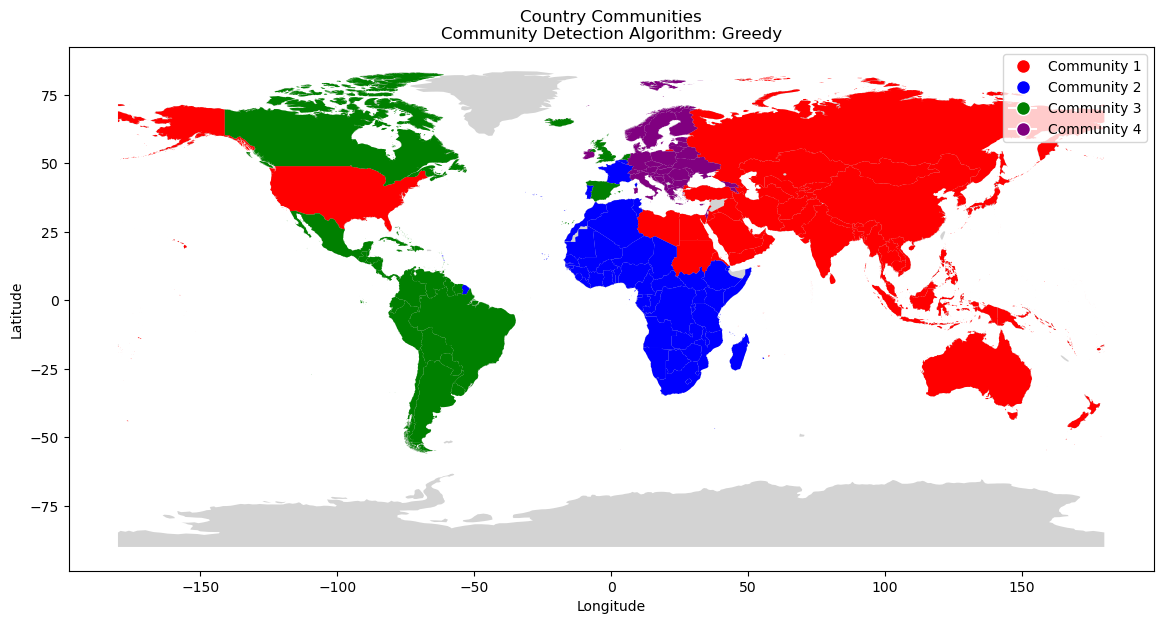

In [158]:
gdf = gpd.GeoDataFrame(nodes_df, geometry='geom')

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

fig, ax = plt.subplots(1, 1, figsize=(14, 10))
world.plot(ax=ax, color='lightgray')

for color in gdf['color'].unique():
    community_gdf = gdf[gdf['color'] == color]
    community_gdf.plot(ax=ax, color=color, markersize=5, label=f'Community {color}')


legend_handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=f'Community {i + 1}')
                  for i, color in enumerate(gdf['color'].unique())]

ax.legend(handles=legend_handles, title="")

plt.title('Country Communities\nCommunity Detection Algorithm: Greedy')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

#### Infomap

In [159]:
#Infomap
for module, nodes in community_list_info.items():
    print(f"Community {module}:")
    region_count = {}
    for node in nodes:
        region = G_scc.nodes[node].get("region")
        if region not in region_count:
            region_count[region] = 0
        region_count[region] += 1
    for region, count in region_count.items():
        print(f"  {region}: {count} nodes")
    print(f'Total nodes: {len(nodes)}')
    print("---")

Community 1:
  South Asia: 8 nodes
  Middle East & North Africa: 16 nodes
  Europe & Central Asia: 48 nodes
  East Asia & Pacific: 17 nodes
  Sub-Saharan Africa: 2 nodes
Total nodes: 91
---
Community 3:
  Sub-Saharan Africa: 25 nodes
  Middle East & North Africa: 2 nodes
Total nodes: 27
---
Community 2:
  Latin America & Caribbean: 33 nodes
  North America: 2 nodes
Total nodes: 35
---
Community 4:
  Middle East & North Africa: 1 nodes
  Sub-Saharan Africa: 21 nodes
Total nodes: 22
---
Community 5:
  East Asia & Pacific: 10 nodes
Total nodes: 10
---
Community 6:
  East Asia & Pacific: 5 nodes
Total nodes: 5
---


In [160]:
#Sort communities by size 
top_communities = sorted(community_list_info.items(), key=lambda x: len(x[1]), reverse=True)[:5]

#Create a color map for the top 5 communities
colors = ['red', 'blue', 'green', 'purple', 'orange']
community_colors = {node: colors[i] for i, (community, nodes) in enumerate(top_communities) for node in nodes}

In [161]:
node_data = []
for node in G_scc.nodes:
    data = G_scc.nodes[node]
    node_data.append({
            'node_id': node,
            'geom': geo_df.loc[geo_df['Country Code'] == node, 'geometry'].values[0],
            'color': community_colors.get(node, 'gray')  #Default to gray if not in top communities
        })

nodes_df = pd.DataFrame(node_data)

C:\Users\annilo\AppData\Local\Temp\ipykernel_29444\1971415284.py:3: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


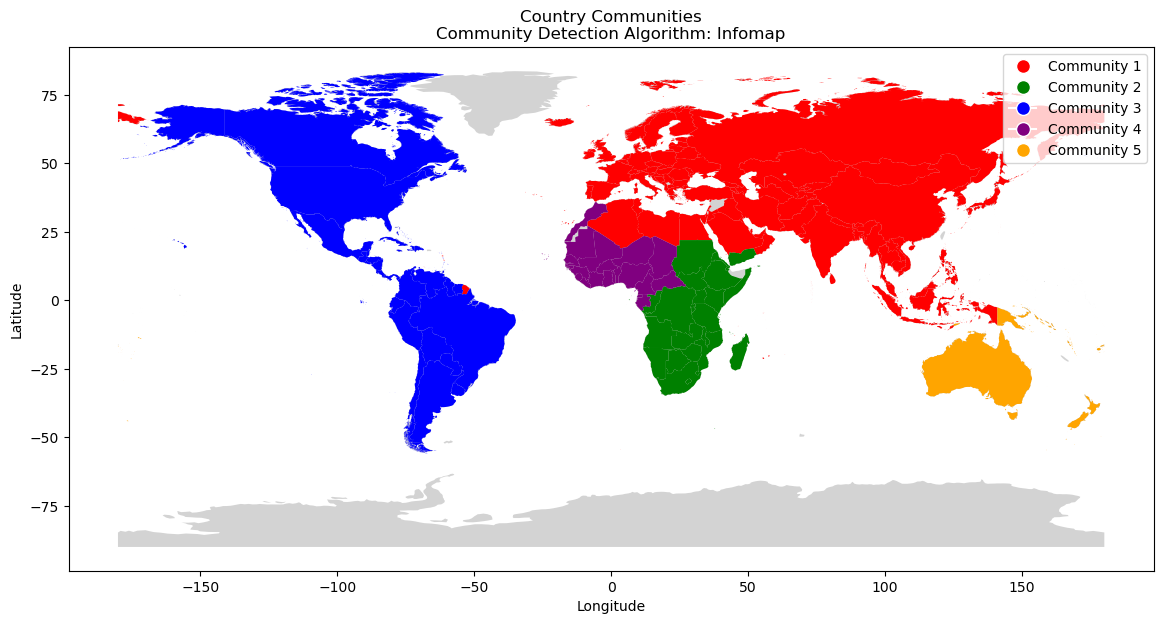

In [162]:
gdf = gpd.GeoDataFrame(nodes_df, geometry='geom')

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

fig, ax = plt.subplots(1, 1, figsize=(14, 10))
world.plot(ax=ax, color='lightgray')

for color in gdf['color'].unique():
    community_gdf = gdf[gdf['color'] == color]
    community_gdf.plot(ax=ax, color=color, markersize=5, label=f'Community {color}')


legend_handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=f'Community {i + 1}')
                  for i, color in enumerate(gdf['color'].unique()) if color != 'gray']

ax.legend(handles=legend_handles, title="")

plt.title('Country Communities\nCommunity Detection Algorithm: Infomap')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

#### Leiden Propagation Algorithm

In [163]:
#LPA
for module, nodes in community_list_lpa.items():
    print(f"Community {module}:")
    region_count = {}
    for node in nodes:
        region = G_scc.nodes[node].get("region")
        if region not in region_count:
            region_count[region] = 0
        region_count[region] += 1
    for region, count in region_count.items():
        print(f"  {region}: {count} nodes")
    print(f'Total nodes: {len(nodes)}')
    print("---")

Community 0:
  Latin America & Caribbean: 33 nodes
  Sub-Saharan Africa: 48 nodes
  Europe & Central Asia: 48 nodes
  East Asia & Pacific: 29 nodes
  Middle East & North Africa: 19 nodes
  South Asia: 8 nodes
  North America: 2 nodes
Total nodes: 187
---
Community 1:
  East Asia & Pacific: 3 nodes
Total nodes: 3
---
